In [50]:
import os
from pathlib import Path
import deepl
import tiktoken as tiktoken
import matplotlib.pyplot as plt
import numpy as np
from langchain.embeddings import OpenAIEmbeddings
from langchain.utils import cosine_similarity
import json
import seaborn as sns

non_latin_languages = ["UK", "EL", "BG", "ZH", "KO", "JA"]

languages = {
    "BG": "Bulgarian",
    "CS": "Czech",
    "DA": "Danish",
    "DE": "German",
    "EL": "Greek",
    "EN-GB": "English UK",
    "EN-US": "English US",
    "ES": "Spanish",
    "ET": "Estonian",
    "FI": "Finnish",
    "FR": "French",
    "HU": "Hungarian",
    "ID": "Indonesian",
    "IT": "Italian",
    "JA": "Japanese",
    "KO": "Korean",
    "LT": "Lithuanian",
    "LV": "Latvian",
    "NB": "Norwegian",
    "NL": "Dutch",
    "PL": "Polish",
    "PT-BR": "Portuguese BR",
    "PT-PT": "Portuguese",
    "RO": "Romanian",
    "SK": "Slovak",
    "SL": "Slovenian",
    "SV": "Swedish",
    "TR": "Turkish",
    "UK": "Ukrainian",
    "ZH": "Chinese",
}

languages_latin = {code:name for code, name in languages.items() if code not in non_latin_languages}

language_codes = list(languages.keys())
language_names = list(languages.values())

language_codes_latin = list(languages_latin.keys())
language_names_latin = list(languages_latin.values())


In [51]:
def calculate_percentage_differences(dict1, dict2):
    percentage_differences = {}
    for key in dict1:
        if key in dict2 and key not in non_latin_languages:
            difference = ((dict2[key] - dict1[key]) / dict1[key]) * 100
            percentage_differences[key] = difference
    return percentage_differences

In [52]:
translator = deepl.Translator(os.environ["DEEPL_KEY"])

source_text = Path("source_text.txt").read_text()

for lang_code in languages.keys():
    destination_path = Path("translations") / f"{lang_code}.txt"

    if destination_path.exists():
        continue

    result = translator.translate_text(source_text, target_lang=lang_code)
    destination_path.write_text(result.text)

In [53]:
import unicodedata

def remove_special_characters(input_str):
    normalized_str = unicodedata.normalize('NFKD', input_str)
    ascii_str = normalized_str.encode('ascii', 'ignore')
    return ascii_str.decode('ascii')

for lang_code in languages.keys():
    translations_path = Path("translations") / f"{lang_code}.txt"
    text_without_special_characters = remove_special_characters(translations_path.read_text())

    destination_path = Path("removed_special_characters") / f"{lang_code}.txt"
    destination_path.write_text(text_without_special_characters)

In [54]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

def count_tokens_in_dir(dir_name: str):
    language_count = {}

    for lang_code, lang_nane in languages.items():
        source_path = Path(dir_name) / f"{lang_code}.txt"
        if not source_path.exists():
            continue

        in_text = source_path.read_text()

        tokens = encoding.encode(in_text)
        tokens_len = len(tokens)

        language_count[lang_code] = tokens_len

    language_count = dict(sorted(language_count.items(), key=lambda item: item[1], reverse=True))

    return language_count

language_token_count = count_tokens_in_dir("translations")
language_token_count_spec_chars_removed = count_tokens_in_dir("removed_special_characters")


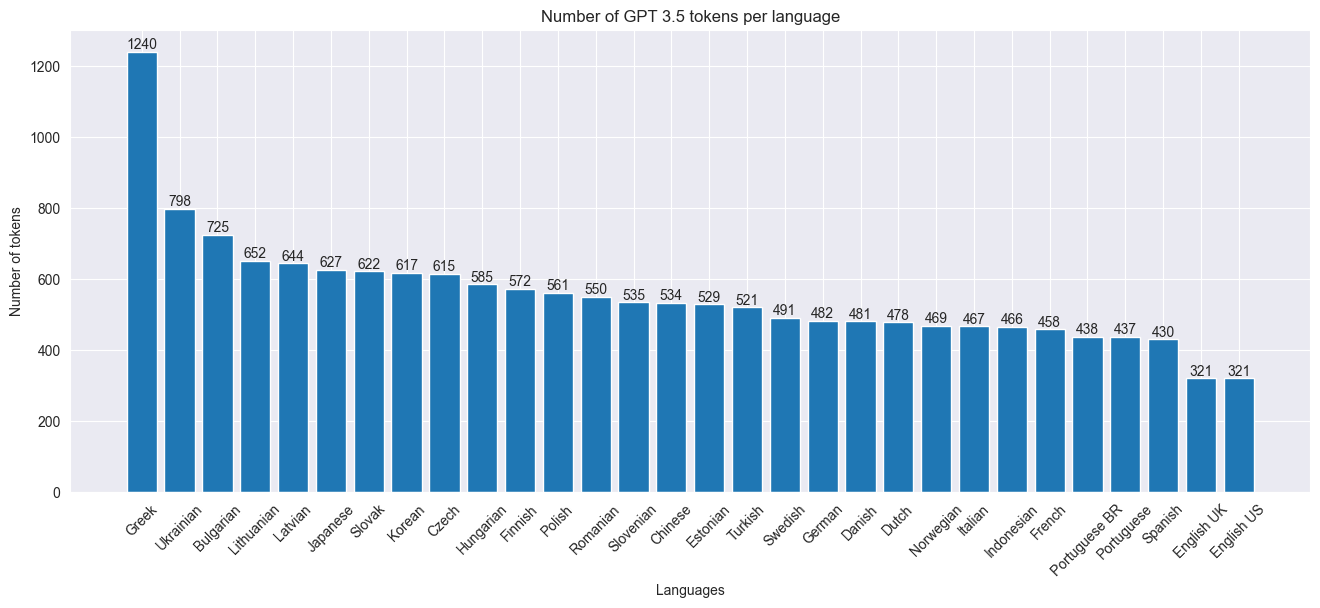

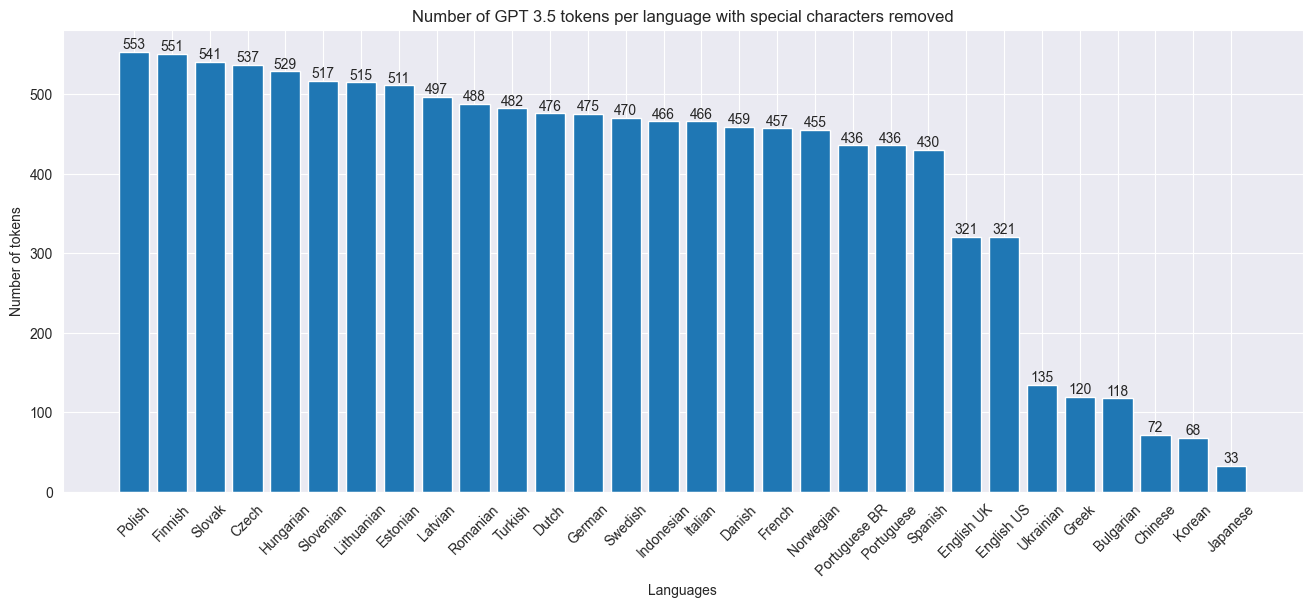

In [55]:
def plot_dict(lang_dict, png_plot_path, plot_title, plot_y_label):
    categories = list(languages[v] for v in lang_dict.keys())
    values = list(lang_dict.values())

    plt.figure(figsize=(16, 6))

    # Creating the bar chart
    bars = plt.bar(categories, values)

    # Adding title and labels
    plt.title(plot_title)
    plt.xlabel('Languages')
    plt.ylabel(plot_y_label)

    plt.xticks(rotation=45)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

    plt.savefig(png_plot_path)
    plt.show()

plot_dict(
    language_token_count,
    "language_token_count.png",
    "Number of GPT 3.5 tokens per language",
    "Number of tokens"
)
plot_dict(
    language_token_count_spec_chars_removed,
    "language_token_count_spec_chars_removed.png",
    "Number of GPT 3.5 tokens per language with special characters removed",
    "Number of tokens"
)

In [56]:
diff_after_removal_special_chars = calculate_percentage_differences(language_token_count, language_token_count_spec_chars_removed)

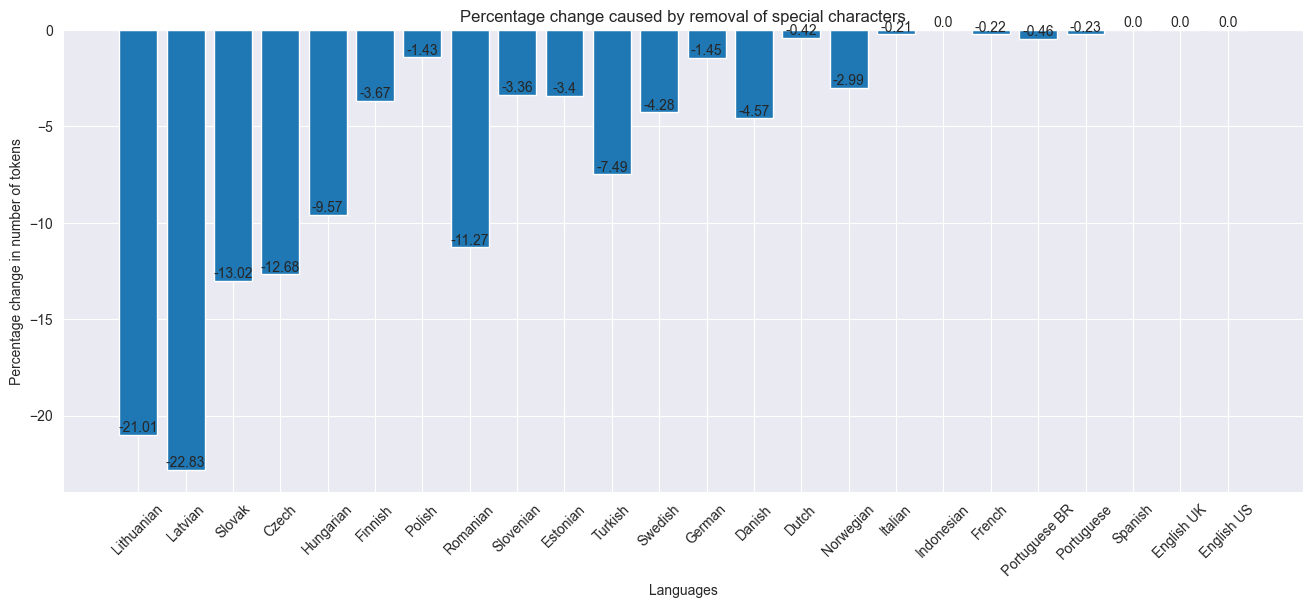

In [57]:
plot_dict(
    diff_after_removal_special_chars,
    "diff_after_removal_special_chars.png",
    "Percentage change caused by removal of special characters",
    "Percentage change in number of tokens"
)

In [58]:
language_codes = list(languages.keys())
language_names = list(languages.values())

In [59]:
def _embed(lang_code: str, txt: str) -> list[float]:
    cache_file = Path("embeddings") / f"{lang_code}.txt"

    if cache_file.exists():
        with Path(cache_file).open("r") as fp:
            return json.load(fp)

    embedding = OpenAIEmbeddings(openai_api_key=os.environ["OPENAI_KEY"]).embed_query(txt)

    with Path(cache_file).open("w") as fp:
        json.dump(embedding, fp)

    return embedding

def _similarity(embed_a: list[float], embed_b: list[float]) -> float:
    return cosine_similarity([embed_a], [embed_b])[0][0]

def compute_relationship(lang_code1, lang_code2):
    source_path_lang1 = Path("translations") / f"{lang_code1}.txt"
    text_lang1 = source_path_lang1.read_text()

    source_path_lang2 = Path("translations") / f"{lang_code2}.txt"
    text_lang2 = source_path_lang2.read_text()

    return _similarity(_embed(lang_code1, text_lang1), _embed(lang_code2, text_lang2))


def compute_relationship_no_special_chars(lang_code1, lang_code2):
    source_path_lang1 = Path("removed_special_characters") / f"{lang_code1}.txt"
    text_lang1 = source_path_lang1.read_text()

    source_path_lang2 = Path("removed_special_characters") / f"{lang_code2}.txt"
    text_lang2 = source_path_lang2.read_text()

    return _similarity(_embed(lang_code1+"_no_special_chars", text_lang1), _embed(lang_code2+"_no_special_chars", text_lang2))

In [65]:
num_languages = len(language_codes)
num_languages_latin = len(language_codes_latin)

relationship_matrix = np.zeros((num_languages, num_languages))
relationship_matrix_no_special_chars = np.zeros((num_languages_latin, num_languages_latin))

for i in range(num_languages):
    for j in range(i, num_languages):
        relationship = compute_relationship(language_codes[i], language_codes[j])

        relationship_matrix[i][j] = relationship

        if i != j:
            relationship_matrix[j][i] = relationship


In [70]:
for i in range(num_languages_latin):
    for j in range(i, num_languages_latin):
        relationship_no_special_chars = compute_relationship_no_special_chars(language_codes_latin[i], language_codes_latin[j])

        relationship_matrix_no_special_chars[i][j] = relationship_no_special_chars

        if i != j:
            relationship_matrix_no_special_chars[j][i] = relationship_no_special_chars

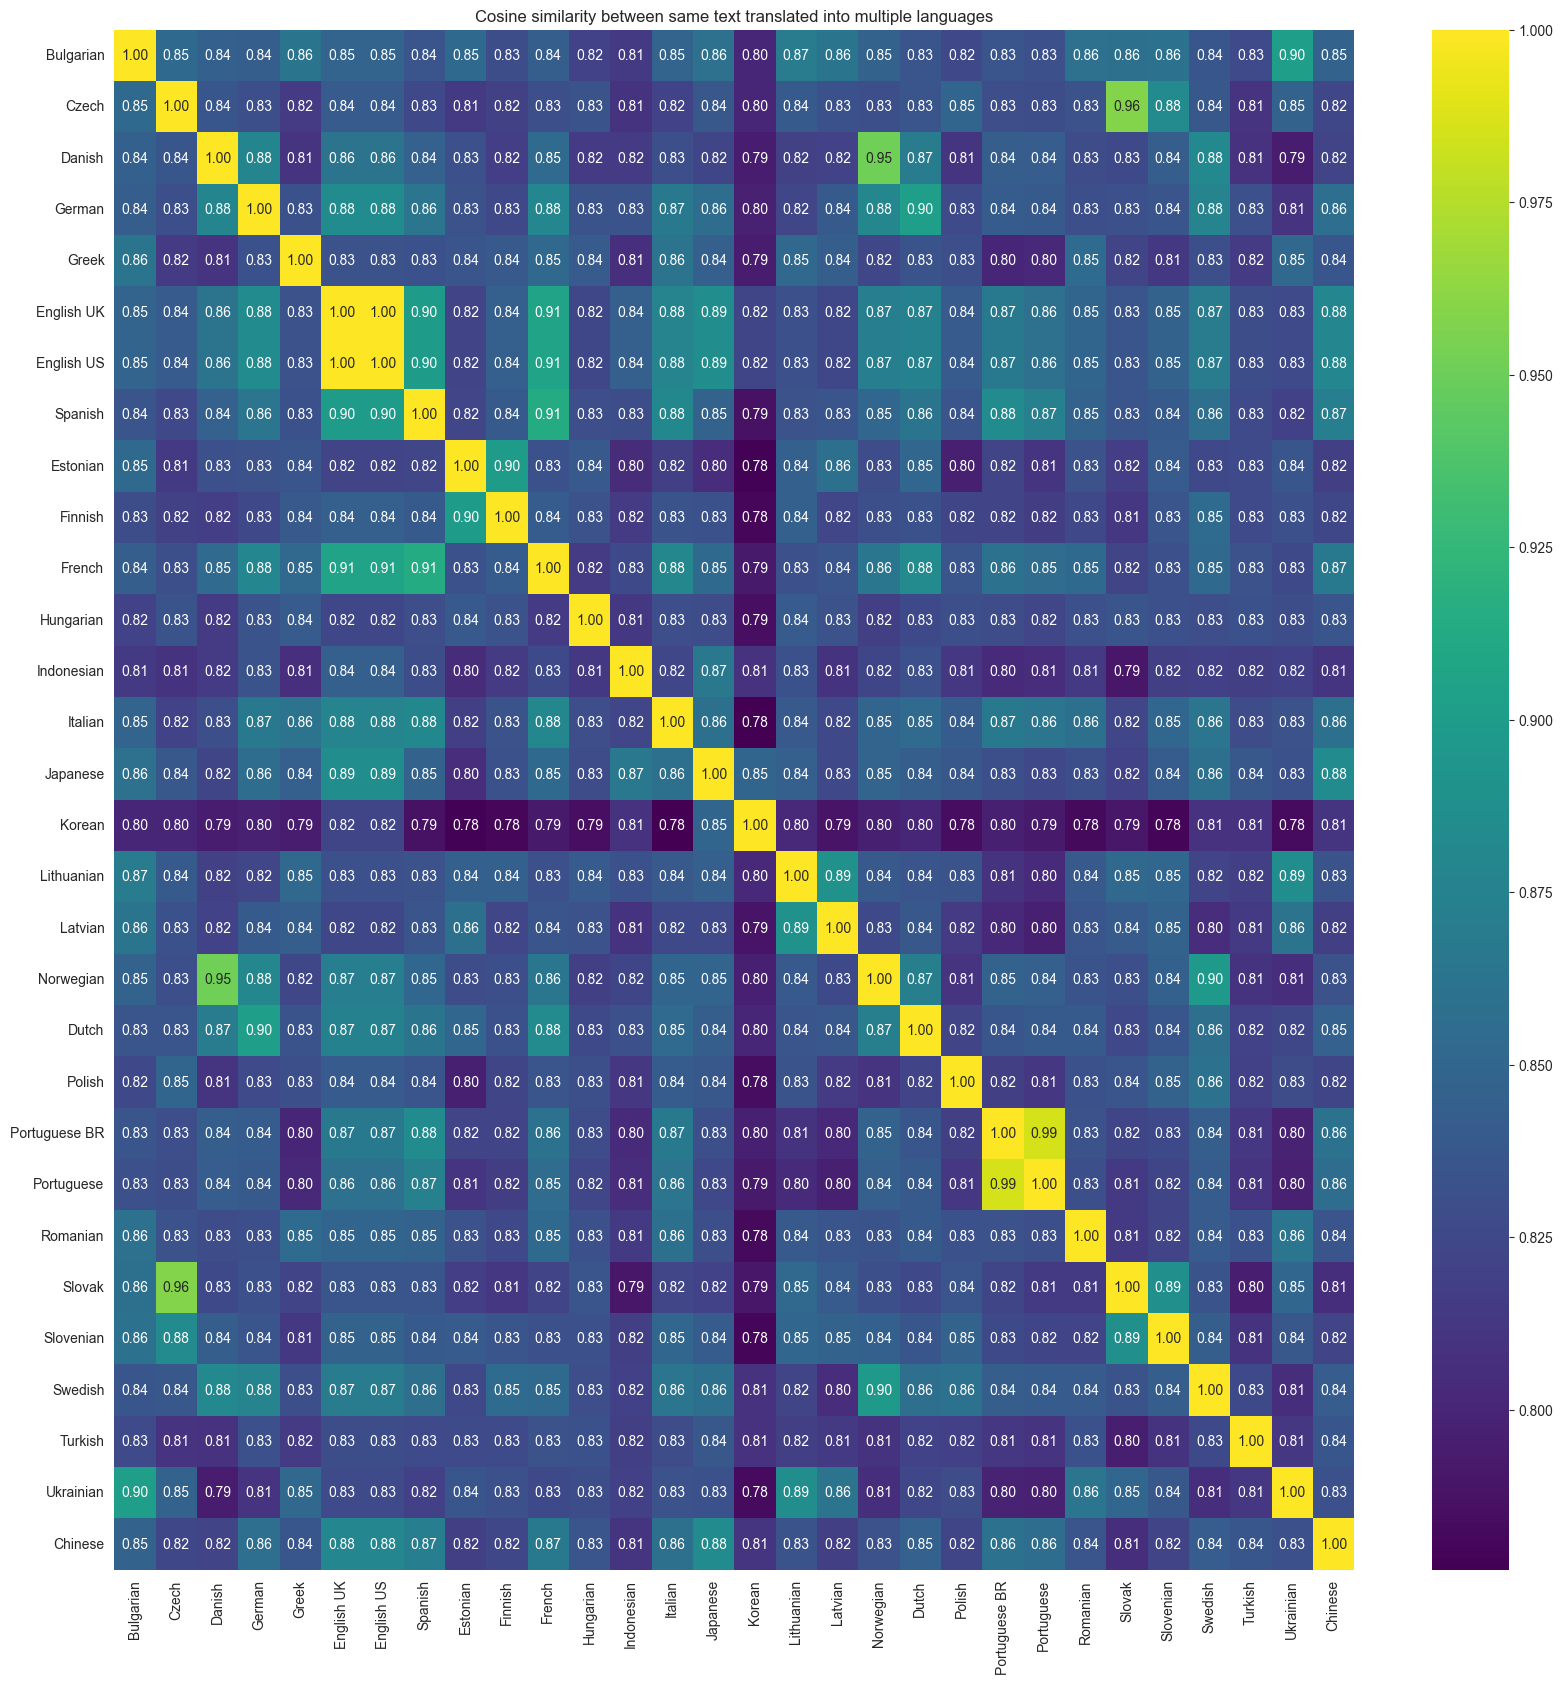

In [71]:
plt.figure(figsize=(20,20))
sns.heatmap(relationship_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.xticks(np.arange(num_languages) + 0.5, language_names, rotation=90)
plt.yticks(np.arange(num_languages) + 0.5, language_names, rotation=0)
plt.title("Cosine similarity between same text translated into multiple languages")
plt.savefig('matrix_original_languages.png')
plt.show()

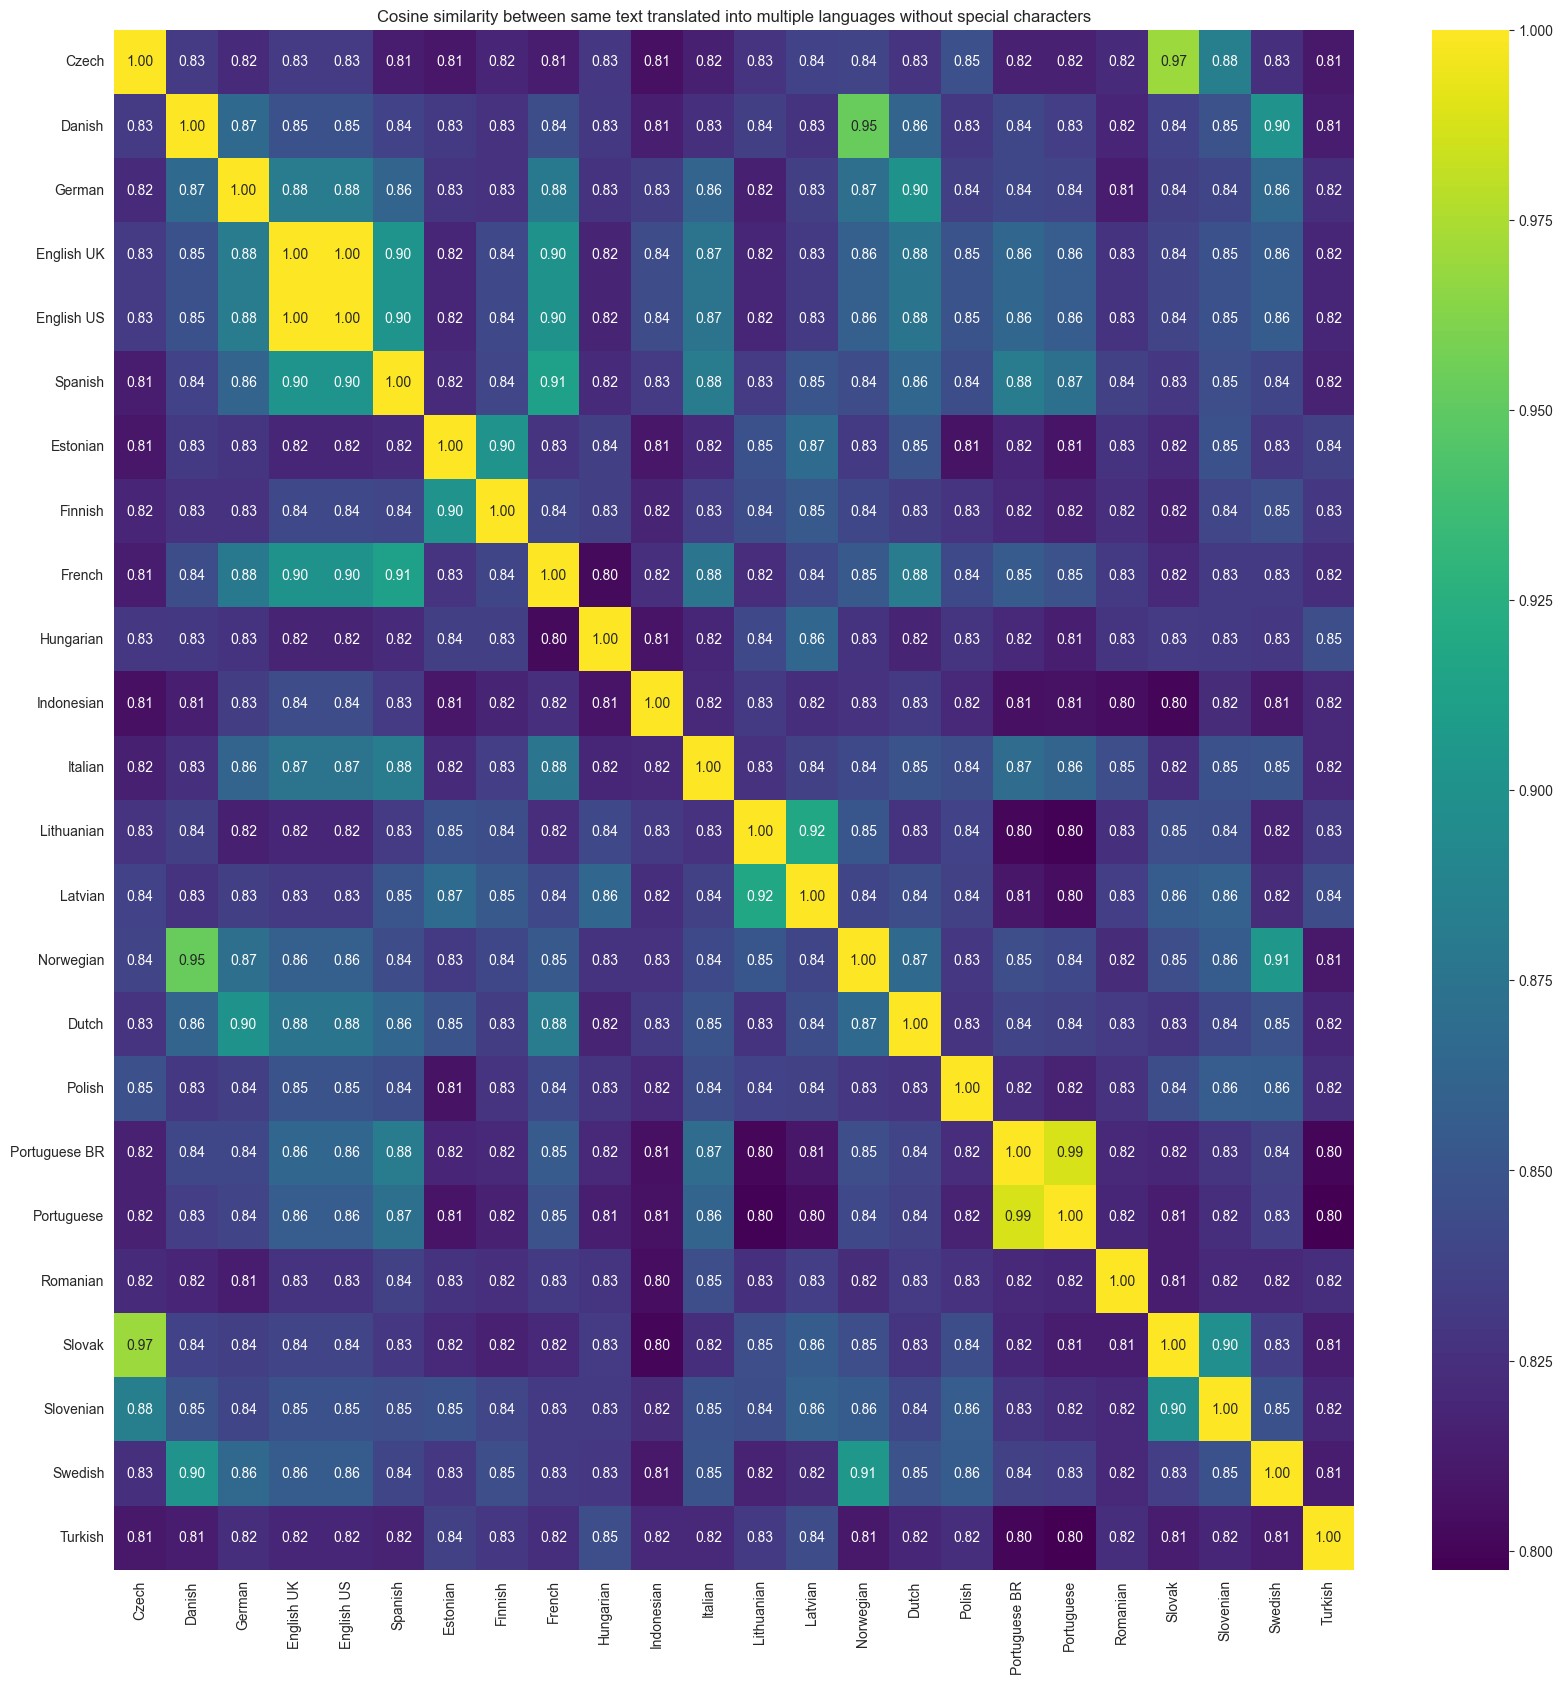

In [73]:
plt.figure(figsize=(20,20))
sns.heatmap(relationship_matrix_no_special_chars, annot=True, fmt=".2f", cmap='viridis')
plt.xticks(np.arange(num_languages_latin) + 0.5, language_names_latin, rotation=90)
plt.yticks(np.arange(num_languages_latin) + 0.5, language_names_latin, rotation=0)
plt.title("Cosine similarity between same text translated into multiple languages without special characters")
plt.savefig('matrix_original_languages_no_latin.png')
plt.show()